# Model Testing Notebook

This notebook tests every model in the `model` folder, including initialization, forward and backward passes, grid generation, and parameter counting.

In [2]:
import torch
import numpy as np
import sys
sys.path.append('./model')
from model.custom_pfnn_kan import KoopmanAE_2d_kan
from model.pfnn import KoopmanAE_2d_trans
from model.pfnn_consist_2d import KoopmanAE_2d
from model.restormer_arch import Restormer
from model.koopman_base import dynamics, dynamics_back
# utilities.py may contain helper functions, not a model class


# Install required packages if not already installed

In [11]:
import sys
import subprocess

def pip_install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--no-cache-dir", package])

try:
    import tvDatafeed
except ImportError:
    pip_install("git+https://github.com/rongardF/tvdatafeed.git")

try:
    import ta
except ImportError:
    pip_install("ta")

try:
    import seaborn
except ImportError:
    pip_install("seaborn")

## Load and Initialize Models

Instantiate each model with example parameters. If pre-trained weights are available, they can be loaded here.

In [12]:
# KoopmanAE_2d_kan example
koopman_model = KoopmanAE_2d_kan(in_channel=1, out_channel=1, dim=4)

# KoopmanAE_2d_trans example (was PFNN)
pfnn_model = KoopmanAE_2d_trans(in_channel=1, out_channel=1, dim=4)

# KoopmanAE_2d example (was PFNNConsist2D)
pfnn_consist_model = KoopmanAE_2d(in_channel=1, out_channel=1, steps=1, steps_back=1)

# Restormer example (parameters may need adjustment based on actual class definition)
restormer_model = Restormer(inp_channels=1, out_channels=1, dim=4)


## Test Forward Dynamics

Pass a sample input tensor through each model in 'forward' mode and print the output shapes.

In [13]:
# Create a dummy input tensor (batch_size=2, channels=1, height=8, width=8)
dummy_input = torch.randn(2, 1, 64, 64)

# KoopmanAE_2d_kan forward
koopman_out, koopman_out_id = koopman_model(dummy_input, mode='forward')
print('KoopmanAE_2d_kan forward output:', [o.shape for o in koopman_out], 'Identity output:', [o.shape for o in koopman_out_id])

# PFNN forward
pfnn_out, pfnn_out_id = pfnn_model(dummy_input)
print('PFNN forward output:', [o.shape for o in pfnn_out], 'Identity output:', [o.shape for o in pfnn_out_id])

# PFNNConsist2D forward
pfnn_consist_out, pfnn_consist_out_id = pfnn_consist_model(dummy_input)
print('PFNNConsist2D forward output:', [o.shape for o in pfnn_consist_out], 'Identity output:', [o.shape for o in pfnn_consist_out_id])

# Restormer forward
restormer_out = restormer_model(dummy_input)
print('Restormer forward output:', restormer_out.shape)


KoopmanAE_2d_kan forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNN forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNNConsist2D forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNN forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNNConsist2D forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
Restormer forward output: torch.Size([2, 1, 64, 64])
Restormer forward output: torch.Size([2, 1, 64, 64])


## Test Backward Dynamics

Pass a sample input tensor through KoopmanAE_2d_kan in 'backward' mode and print the output shapes.

In [14]:
koopman_back_out, koopman_back_out_id = koopman_model(dummy_input, mode='backward')
print('KoopmanAE_2d_kan backward output:', [o.shape for o in koopman_back_out], 'Identity output:', [o.shape for o in koopman_back_out_id])

KoopmanAE_2d_kan backward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]


## Test Grid Generation

Call the get_grid method with sample parameters and print the grid shape.

In [15]:
grid = koopman_model.get_grid(S=8, batchsize=2, device=dummy_input.device)
print('Generated grid shape:', grid.shape)

Generated grid shape: torch.Size([2, 2, 8, 8])


## Count Model Parameters

Use the count_params method (if available) or sum up parameters for each model and print the total.

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('KoopmanAE_2d_kan parameters:', koopman_model.count_params() if hasattr(koopman_model, 'count_params') else count_parameters(koopman_model))
print('KoopmanAE_2d_trans parameters:', count_parameters(pfnn_model))
print('KoopmanAE_2d parameters:', count_parameters(pfnn_consist_model))
print('Restormer parameters:', count_parameters(restormer_model))

KoopmanAE_2d_kan parameters: 60873
KoopmanAE_2d_trans parameters: 180912
KoopmanAE_2d parameters: 740641
Restormer parameters: 226000


## Test Simple PFNN Model

This section tests the new PFNN class from model.pfnn_simple.py.

In [17]:
# Test the simple PFNN model
from model.pfnn_simple import PFNN

latent_dim = 16
pfnn_simple = PFNN(latent_dim=latent_dim)

# Create a dummy input (batch_size=2, latent_dim=16)
dummy_z = torch.randn(2, latent_dim)

# Test all modes
for mode in ['contract', 'invariant', 'inverse']:
    out = pfnn_simple(dummy_z, mode=mode)
    print(f'PFNN forward output (mode={mode}):', out.shape)

# Test regularization methods
unitary_reg = pfnn_simple.get_unitary_regularization()
contraction_reg = pfnn_simple.get_contraction_regularization()
print('Unitary regularization:', unitary_reg.item())
print('Contraction regularization:', contraction_reg.item())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Simple PFNN parameters:', count_parameters(pfnn_simple))

PFNN forward output (mode=contract): torch.Size([2, 16])
PFNN forward output (mode=invariant): torch.Size([2, 16])
PFNN forward output (mode=inverse): torch.Size([2, 16])
Unitary regularization: 8.516561508178711
Contraction regularization: 0.8977614045143127
Simple PFNN parameters: 5024


# --- Compare PFNN rollout to true latent trajectory ---

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import directed_hausdorff
import seaborn as sns

def compare_rollout_to_true(z_pred, z_true, label_pred="PFNN", label_true="Real", mode="pca"):
    from sklearn.decomposition import PCA
    from sklearn.metrics import mean_squared_error
    from scipy.spatial.distance import directed_hausdorff
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure both arrays have the same number of features for PCA
    min_dim = min(z_pred.shape[1], z_true.shape[1])
    z_pred_crop = z_pred[:, :min_dim]
    z_true_crop = z_true[:, :min_dim]

    if mode == "pca":
        pca = PCA(n_components=2)
        all_data = np.vstack([z_pred_crop, z_true_crop])
        z_pca = pca.fit_transform(all_data)
        z_pred_2d = z_pca[:len(z_pred)]
        z_true_2d = z_pca[len(z_pred):]
    else:
        z_pred_2d = z_pred_crop
        z_true_2d = z_true_crop

    plt.figure(figsize=(7, 6))
    plt.plot(z_true_2d[:, 0], z_true_2d[:, 1], alpha=0.6, label=label_true, color='blue')
    plt.plot(z_pred_2d[:, 0], z_pred_2d[:, 1], alpha=0.6, label=label_pred, color='red')
    plt.title("Latent Attractor: Real vs PFNN")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(z_true_2d[:len(z_pred_2d)], z_pred_2d)
    hausdorff_fwd = directed_hausdorff(z_pred_2d, z_true_2d)[0]
    hausdorff_bwd = directed_hausdorff(z_true_2d, z_pred_2d)[0]
    hausdorff = max(hausdorff_fwd, hausdorff_bwd)
    print(f"🔍 MSE (rollout vs true): {mse:.5f}")
    print(f"📐 Hausdorff Distance: {hausdorff:.5f}")

# Example usage (ensure z_pred and z_true are available in your notebook):
# embedded = multi_embed(data_scaled, delay=1, dimension=3)
# z_true = PCA(n_components=latent_dim).fit_transform(embedded)
# z_true = (z_true - z_true.mean(0)) / z_true.std(0)
# compare_rollout_to_true(z_pred, z_true)

In [20]:
from tvDatafeed import TvDatafeed, Interval
import ta
# from pfnn import PFNN
# from pyts.image import RecurrencePlot
# from nolitsa import lyapunov
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load and preprocess data
tv = TvDatafeed()
df = tv.get_hist('SET', 'SET', interval=Interval.in_daily, n_bars=1200).dropna()
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['volatility'] = df['log_return'].rolling(window=10).std()
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['macd'] = ta.trend.MACD(df['close']).macd_diff()
df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close'], window=14).adx()

features = ['log_return', 'volume', 'volatility', 'rsi', 'macd', 'adx']
data = df[features].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

you are using nologin method, data you access may be limited


KoopmanAE_2d_kan rollout complete.
KoopmanAE_2d_trans rollout complete.
KoopmanAE_2d (consist) rollout complete.
PFNN_simple rollout complete.

=== KoopmanAE_2d_kan ===
PFNN_simple rollout complete.

=== KoopmanAE_2d_kan ===


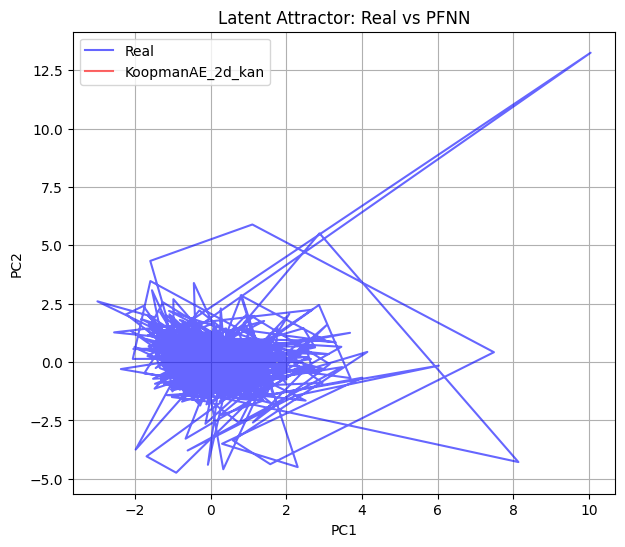

🔍 MSE (rollout vs true): 0.34745
📐 Hausdorff Distance: 17.01443

=== KoopmanAE_2d_trans ===


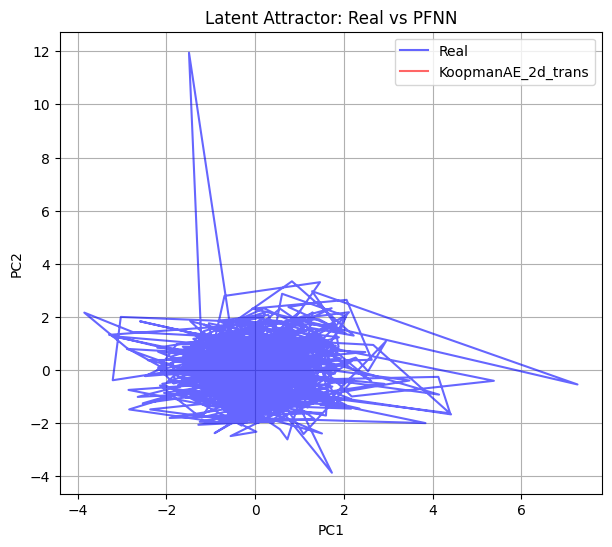

🔍 MSE (rollout vs true): 0.02007
📐 Hausdorff Distance: 12.00748

=== KoopmanAE_2d ===


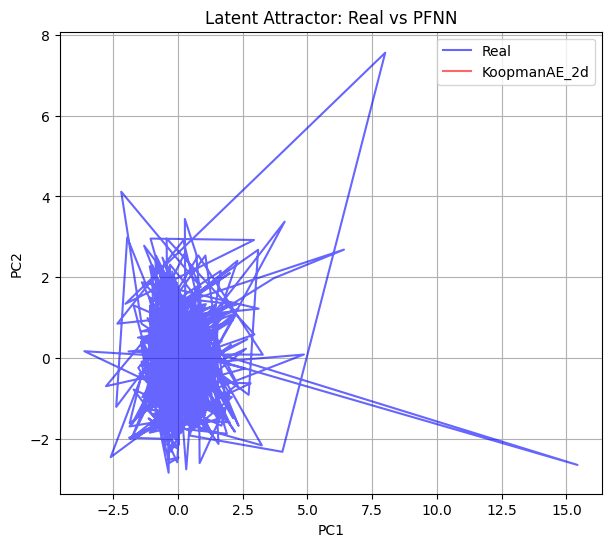

🔍 MSE (rollout vs true): 0.23041
📐 Hausdorff Distance: 16.22920

=== PFNN_simple ===


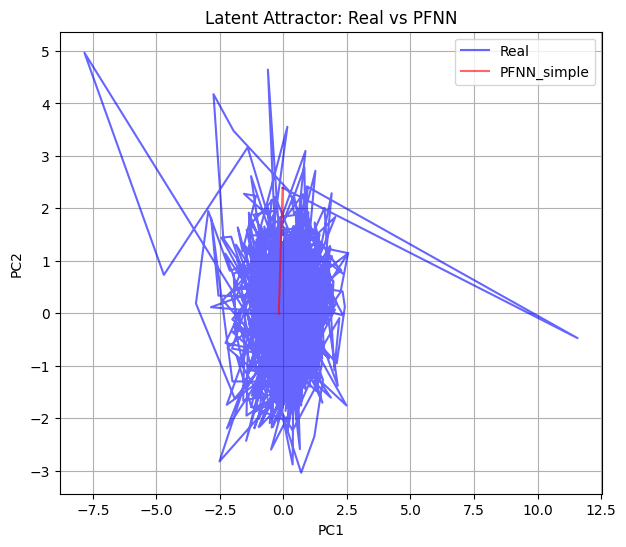

🔍 MSE (rollout vs true): 1.05571
📐 Hausdorff Distance: 11.75280


In [33]:
# --- Compare rollout to true latent for all models ---
from model.custom_pfnn_kan import KoopmanAE_2d_kan
from model.pfnn import KoopmanAE_2d_trans
from model.pfnn_consist_2d import KoopmanAE_2d
from model.pfnn_simple import PFNN
from sklearn.decomposition import PCA
import torch
import numpy as np

def multi_embed(data, delay=1, dimension=3):
    N, D = data.shape
    M = N - (dimension - 1) * delay
    embedded = np.zeros((M, D * dimension))
    for i in range(dimension):
        embedded[:, i * D:(i + 1) * D] = data[i * delay: i * delay + M]
    return embedded

latent_dim = 16  # or 18, depending on your experiment
embedded = multi_embed(data_scaled, delay=1, dimension=3)
z_true = PCA(n_components=latent_dim).fit_transform(embedded)
z_true = (z_true - z_true.mean(0)) / z_true.std(0)
z_true_tensor = torch.tensor(z_true, dtype=torch.float32)

def get_real_image_input(data_scaled, idx=0, height=64, width=64):
    sample = data_scaled[idx]
    img = np.tile(sample, (height, width, 1)).transpose(2, 0, 1)  # [C, H, W]
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)     # [1, C, H, W]
    return img

def rollout_pfnn(model, z0, k_contract, k_total, contract_mode='contract', invariant_mode='invariant'):
    z = [z0]
    model.eval()
    with torch.no_grad():
        for _ in range(k_contract - 1):
            z.append(model(z[-1].unsqueeze(0), mode=contract_mode).squeeze(0))
        for _ in range(k_total - k_contract):
            z.append(model(z[-1].unsqueeze(0), mode=invariant_mode).squeeze(0))
    return torch.stack(z).detach().cpu().numpy()

def rollout_koopman(model, real_input, steps):
    model.eval()
    with torch.no_grad():
        out, _ = model(real_input, mode='forward')
        z_pred = torch.stack([o.flatten() for o in out]).cpu().numpy()
    return z_pred

k = int(len(z_true) * 0.3)
z0 = z_true_tensor[0]
k_total = len(z_true)
k_contract = k
model_results = {}

real_input = get_real_image_input(data_scaled, idx=0, height=64, width=64)

# 1. KoopmanAE_2d_kan
try:
    koopman_model = KoopmanAE_2d_kan(in_channel=6, out_channel=1, dim=4)
    z_pred_kan = rollout_koopman(koopman_model, real_input, steps=1)
    model_results['KoopmanAE_2d_kan'] = z_pred_kan
    print("KoopmanAE_2d_kan rollout complete.")
except Exception as e:
    print("KoopmanAE_2d_kan failed:", e)

# 2. KoopmanAE_2d_trans
try:
    pfnn_model = KoopmanAE_2d_trans(in_channel=6, out_channel=1, dim=4)
    z_pred_trans = rollout_koopman(pfnn_model, real_input, steps=1)
    model_results['KoopmanAE_2d_trans'] = z_pred_trans
    print("KoopmanAE_2d_trans rollout complete.")
except Exception as e:
    print("KoopmanAE_2d_trans failed:", e)

# 3. KoopmanAE_2d (consist)
try:
    pfnn_consist_model = KoopmanAE_2d(in_channel=6, out_channel=1, steps=1, steps_back=1)
    z_pred_consist = rollout_koopman(pfnn_consist_model, real_input, steps=1)
    model_results['KoopmanAE_2d'] = z_pred_consist
    print("KoopmanAE_2d (consist) rollout complete.")
except Exception as e:
    print("KoopmanAE_2d (consist) failed:", e)

# 4. PFNN (simple)
try:
    pfnn_simple = PFNN(latent_dim=latent_dim)
    z_pred_simple = rollout_pfnn(pfnn_simple, z0, k_contract, k_total)
    model_results['PFNN_simple'] = z_pred_simple
    print("PFNN_simple rollout complete.")
except Exception as e:
    print("PFNN_simple failed:", e)

for model_name, z_pred in model_results.items():
    print(f"\n=== {model_name} ===")
    compare_rollout_to_true(z_pred, z_true, label_pred=model_name, label_true="Real", mode="pca")

## Load and Initialize Models

Instantiate each model with example parameters. If pre-trained weights are available, they can be loaded here.

In [23]:
# KoopmanAE_2d_kan example
koopman_model = KoopmanAE_2d_kan(in_channel=1, out_channel=1, dim=4)

# KoopmanAE_2d_trans example (was PFNN)
pfnn_model = KoopmanAE_2d_trans(in_channel=1, out_channel=1, dim=4)

# KoopmanAE_2d example (was PFNNConsist2D)
pfnn_consist_model = KoopmanAE_2d(in_channel=1, out_channel=1, steps=1, steps_back=1)

# Restormer example (parameters may need adjustment based on actual class definition)
restormer_model = Restormer(inp_channels=1, out_channels=1, dim=4)


## Test Forward Dynamics

Pass a sample input tensor through each model in 'forward' mode and print the output shapes.

In [24]:
# Create a dummy input tensor (batch_size=2, channels=1, height=8, width=8)
dummy_input = torch.randn(2, 1, 64, 64)

# KoopmanAE_2d_kan forward
koopman_out, koopman_out_id = koopman_model(dummy_input, mode='forward')
print('KoopmanAE_2d_kan forward output:', [o.shape for o in koopman_out], 'Identity output:', [o.shape for o in koopman_out_id])

# PFNN forward
pfnn_out, pfnn_out_id = pfnn_model(dummy_input)
print('PFNN forward output:', [o.shape for o in pfnn_out], 'Identity output:', [o.shape for o in pfnn_out_id])

# PFNNConsist2D forward
pfnn_consist_out, pfnn_consist_out_id = pfnn_consist_model(dummy_input)
print('PFNNConsist2D forward output:', [o.shape for o in pfnn_consist_out], 'Identity output:', [o.shape for o in pfnn_consist_out_id])

# Restormer forward
restormer_out = restormer_model(dummy_input)
print('Restormer forward output:', restormer_out.shape)


KoopmanAE_2d_kan forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNN forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
PFNNConsist2D forward output: [torch.Size([2, 1, 64, 64])] Identity output: [torch.Size([2, 1, 64, 64])]
Restormer forward output: torch.Size([2, 1, 64, 64])


## Test Backward Dynamics

Pass a sample input tensor through KoopmanAE_2d_kan in 'backward' mode and print the output shapes.

In [ ]:
koopman_back_out, koopman_back_out_id = koopman_model(dummy_input, mode='backward')
print('KoopmanAE_2d_kan backward output:', [o.shape for o in koopman_back_out], 'Identity output:', [o.shape for o in koopman_back_out_id])

## Test Grid Generation

Call the get_grid method with sample parameters and print the grid shape.

In [ ]:
grid = koopman_model.get_grid(S=8, batchsize=2, device=dummy_input.device)
print('Generated grid shape:', grid.shape)

## Count Model Parameters

Use the count_params method (if available) or sum up parameters for each model and print the total.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('KoopmanAE_2d_kan parameters:', koopman_model.count_params() if hasattr(koopman_model, 'count_params') else count_parameters(koopman_model))
print('KoopmanAE_2d_trans parameters:', count_parameters(pfnn_model))
print('KoopmanAE_2d parameters:', count_parameters(pfnn_consist_model))
print('Restormer parameters:', count_parameters(restormer_model))

## Test Simple PFNN Model

This section tests the new PFNN class from model.pfnn_simple.py.

In [ ]:
# Test the simple PFNN model
from model.pfnn_simple import PFNN

latent_dim = 16
pfnn_simple = PFNN(latent_dim=latent_dim)

# Create a dummy input (batch_size=2, latent_dim=16)
dummy_z = torch.randn(2, latent_dim)

# Test all modes
for mode in ['contract', 'invariant', 'inverse']:
    out = pfnn_simple(dummy_z, mode=mode)
    print(f'PFNN forward output (mode={mode}):', out.shape)

# Test regularization methods
unitary_reg = pfnn_simple.get_unitary_regularization()
contraction_reg = pfnn_simple.get_contraction_regularization()
print('Unitary regularization:', unitary_reg.item())
print('Contraction regularization:', contraction_reg.item())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Simple PFNN parameters:', count_parameters(pfnn_simple))

# --- Compare PFNN rollout to true latent trajectory ---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import directed_hausdorff
import seaborn as sns

def compare_rollout_to_true(z_pred, z_true, label_pred="PFNN", label_true="Real", mode="pca"):
    from sklearn.decomposition import PCA
    from sklearn.metrics import mean_squared_error
    from scipy.spatial.distance import directed_hausdorff
    import matplotlib.pyplot as plt
    import numpy as np

    # Ensure both arrays have the same number of features for PCA
    min_dim = min(z_pred.shape[1], z_true.shape[1])
    z_pred_crop = z_pred[:, :min_dim]
    z_true_crop = z_true[:, :min_dim]

    if mode == "pca":
        pca = PCA(n_components=2)
        all_data = np.vstack([z_pred_crop, z_true_crop])
        z_pca = pca.fit_transform(all_data)
        z_pred_2d = z_pca[:len(z_pred)]
        z_true_2d = z_pca[len(z_pred):]
    else:
        z_pred_2d = z_pred_crop
        z_true_2d = z_true_crop

    plt.figure(figsize=(7, 6))
    plt.plot(z_true_2d[:, 0], z_true_2d[:, 1], alpha=0.6, label=label_true, color='blue')
    plt.plot(z_pred_2d[:, 0], z_pred_2d[:, 1], alpha=0.6, label=label_pred, color='red')
    plt.title("Latent Attractor: Real vs PFNN")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

    mse = mean_squared_error(z_true_2d[:len(z_pred_2d)], z_pred_2d)
    hausdorff_fwd = directed_hausdorff(z_pred_2d, z_true_2d)[0]
    hausdorff_bwd = directed_hausdorff(z_true_2d, z_pred_2d)[0]
    hausdorff = max(hausdorff_fwd, hausdorff_bwd)
    print(f"🔍 MSE (rollout vs true): {mse:.5f}")
    print(f"📐 Hausdorff Distance: {hausdorff:.5f}")

# Example usage (ensure z_pred and z_true are available in your notebook):
# embedded = multi_embed(data_scaled, delay=1, dimension=3)
# z_true = PCA(n_components=latent_dim).fit_transform(embedded)
# z_true = (z_true - z_true.mean(0)) / z_true.std(0)
# compare_rollout_to_true(z_pred, z_true)

In [ ]:
# --- Compare rollout to true latent for all models ---
from model.custom_pfnn_kan import KoopmanAE_2d_kan
from model.pfnn import KoopmanAE_2d_trans
from model.pfnn_consist_2d import KoopmanAE_2d
from model.pfnn_simple import PFNN
from sklearn.decomposition import PCA
import torch
import numpy as np

def multi_embed(data, delay=1, dimension=3):
    N, D = data.shape
    M = N - (dimension - 1) * delay
    embedded = np.zeros((M, D * dimension))
    for i in range(dimension):
        embedded[:, i * D:(i + 1) * D] = data[i * delay: i * delay + M]
    return embedded

latent_dim = 16  # or 18, depending on your experiment
embedded = multi_embed(data_scaled, delay=1, dimension=3)
z_true = PCA(n_components=latent_dim).fit_transform(embedded)
z_true = (z_true - z_true.mean(0)) / z_true.std(0)
z_true_tensor = torch.tensor(z_true, dtype=torch.float32)

# Rollout for PFNN (latent vector)
def rollout_pfnn(model, z0, k_contract, k_total, contract_mode='contract', invariant_mode='invariant'):
    z = [z0]
    model.eval()
    with torch.no_grad():
        for _ in range(k_contract - 1):
            z.append(model(z[-1].unsqueeze(0), mode=contract_mode).squeeze(0))
        for _ in range(k_total - k_contract):
            z.append(model(z[-1].unsqueeze(0), mode=invariant_mode).squeeze(0))
    return torch.stack(z).detach().cpu().numpy()

# Rollout for KoopmanAE_2d_* models (image input, compare output via PCA)
def rollout_koopman(model, real_input, steps):
    model.eval()
    with torch.no_grad():
        out, _ = model(real_input, mode='forward')
        z_pred = torch.stack([o.flatten() for o in out]).cpu().numpy()
    return z_pred

k = int(len(z_true) * 0.3)
z0 = z_true_tensor[0]
k_total = len(z_true)
k_contract = k
model_results = {}

real_input = get_real_image_input(data_scaled, idx=0, height=64, width=64)

# 1. KoopmanAE_2d_kan
try:
    koopman_model = KoopmanAE_2d_kan(in_channel=6, out_channel=1, dim=4)
    dummy_input = torch.randn(1, 6, 64, 64)  # or use a real sample
    z_pred_kan = rollout_koopman(koopman_model, dummy_input, steps=1)
    model_results['KoopmanAE_2d_kan'] = z_pred_kan
    print("KoopmanAE_2d_kan rollout complete.")
except Exception as e:
    print("KoopmanAE_2d_kan failed:", e)

# 2. KoopmanAE_2d_trans
try:
    pfnn_model = KoopmanAE_2d_trans(in_channel=6, out_channel=1, dim=4)
    dummy_input = torch.randn(1, 6, 64, 64)
    z_pred_trans = rollout_koopman(pfnn_model, dummy_input, steps=1)
    model_results['KoopmanAE_2d_trans'] = z_pred_trans
    print("KoopmanAE_2d_trans rollout complete.")
except Exception as e:
    print("KoopmanAE_2d_trans failed:", e)

# 3. KoopmanAE_2d (consist)
try:
    pfnn_consist_model = KoopmanAE_2d(in_channel=6, out_channel=1, steps=1, steps_back=1)
    dummy_input = torch.randn(1, 6, 64, 64)
    z_pred_consist = rollout_koopman(pfnn_consist_model, dummy_input, steps=1)
    model_results['KoopmanAE_2d'] = z_pred_consist
    print("KoopmanAE_2d (consist) rollout complete.")
except Exception as e:
    print("KoopmanAE_2d (consist) failed:", e)

# 4. PFNN (simple)
try:
    pfnn_simple = PFNN(latent_dim=latent_dim)
    z_pred_simple = rollout_pfnn(pfnn_simple, z0, k_contract, k_total)
    model_results['PFNN_simple'] = z_pred_simple
    print("PFNN_simple rollout complete.")
except Exception as e:
    print("PFNN_simple failed:", e)

for model_name, z_pred in model_results.items():
    print(f"\n=== {model_name} ===")
    compare_rollout_to_true(z_pred, z_true, label_pred=model_name, label_true="Real", mode="pca")